# Week 5 - Natural Language Processing (NLP)

In this week's exercise, we will apply neural networks to a new type of data - text. You will also pick your own corpus of text to play with.  **But first, some definitions** (there's a lot of new jargon in 'NLP'):
* *Corpus*: The set of all text documents you want to work on
* *Document*: An individual unit of text in your corpus

Below are some **examples of corpora** to get you thinking:

* Corpus of 100,000 IMDB reviews, where each document is an individual review
* Corpus of 20 English novels, where each document is an individual novel
* Corpus of one Malay novel, where each document is a chapter

You can **browse for a corpus in the below links** (if you don't already have one in mind):

* https://github.com/niderhoff/nlp-datasets
* https://www.gutenberg.org/catalog/

If this is your first time working with text, it's probably easier to deal with a corpus of many short documents - for example the IMDB review dataset, which is linked below in Chapter 2.  Play around with several corpora over the course of week, and work with something that interests you. Remember text doesn't have to be English (try other languages), or even a natural language (try code or musical notation)!

**Key learning resources** for the week:
* https://web.stanford.edu/~jurafsky/slp3/ - legendary textbook introducing key theory and concepts of working with text, up to deep learning methods
* http://web.stanford.edu/class/cs224n/ - great course that introduces theory and concepts of text processing in the context of deep learning (can read class notes / assignments and skip videos if you are short on time) 
* https://course.fast.ai/index.html - fast.ai's introduction to deep learning (you'll have to pick out the bits about text and RNNs) is an efficient and effective way of tackling the topic
* https://www.datacamp.com/courses/natural-language-processing-fundamentals-in-python - very hands on datacamp course that will let you practice using existing tools for NLP tasks

Some **additional tools below** that can help in NLP (if you haven't found them already):
* scikit-learn has a handy set of features for NLP
* https://spacy.io/ - commercially oriented python package for NLP
* https://www.nltk.org/ - slightly more academic oriented python package for NLP 

## Imports

In [52]:
import numpy as np  # a conventional alias
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from src.preprocess import getFileNames
from scipy.cluster import  hierarchy
from scipy.cluster.hierarchy import linkage,dendrogram,cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
from sklearn.model_selection import GridSearchCV

# Chapter 1: How do we turn text into data we can use?

### Convert your corpus into bags of words

We can't apply any of the techniques we have learned over the past few weeks directly on raw text.  Therefore, our first task is to convert our corpus into numbers.  The simplest way to do this is to use a **bag of words**. You can see some examples of this here: https://liferay.de.dariah.eu/tatom/index.html.

Once you understand the concept, convert your corpus and documents into bags of words below:

- Using the IMDB movies reviews
- Unsup dataset is used

In [5]:
mypath='/home/hanifa/workspace/AIAP/AIAP_Week5/aclImdb/train/tt'
# mypath='/home/jupyter/AIAP_Week5/aclImdb/train/unsup/'
filenames=getFileNames(mypath)

In [9]:
def checkVectorizer(dtm):
    a=dtm.sum(axis=0)
    a.sort(axis=0)
    print(a)

- Was having memory errors loading all the unsup data, thus just took a sample of 7K.
- Stopwords were iteratively added.

In [7]:
from sklearn.feature_extraction import text 
my_additional_stop_words=['br','film','movie']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

vectorizer = CountVectorizer(input='filename',stop_words=stop_words,max_df=1000)
# vectorizer = CountVectorizer(input='filename',stop_words='english')'
dtm = vectorizer.fit_transform(filenames)  # a sparse matrix 
vocab = vectorizer.get_feature_names()

# type(dtm)                                         
dtm = dtm.toarray()  # convert to a regular array 
vocab = np.array(vocab)

In [15]:
# checkVectorizer(dtm)
dtm.shape

(17, 1000)

### Show us your bags

Show and explain what one of your documents looks like as a bag of words below.  What are the advantages and disadvantages of encoding text as bags of words?

- The column represents the words and the rows the document itself. 
- By summing up the column, we can total frequency across all documents

__Bag of Words Representation__

In [67]:
df=pd.DataFrame(dtm, columns=vocab)
df[vocab[0:20]].head()

,04,12,15,1927,1928,1931,1933,1st,20,2007,23,27,29,31,40,49,64,68,abbott,aboard
0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
#Clears Memory
del df

In [35]:
def getFrequentWord(dtm):
    dtm_sum=dtm.sum(axis=0)
    idx=dtm_sum.argmax(axis=0)
    print("Most frequent word: %s" %(vocab[idx]))

In [36]:
getFrequentWord(dtm)

Most frequent word: boyd


Cons:
 - Most frequent words are considered the most important
 - The context of the word is ignored

### Tell us a story with your bags
Now that your text is in a more digestible format, you can apply previously learned techniques to better understand the corpus. **Create a brief story around your corpus, for example by using clustering techniques.** Some examples of what you can do below:

* Use Hierarchical Clustering to understand similarity of documents in your corpus. What distance measure works best? Are the results what you expect?
- Comparing Euclidean and Cosine, Cosine seems better as it <br/>
[Hierarchial Clustering Code](https://datascience.stackexchange.com/questions/22828/clustering-with-cosine-similarity/22834)

__Hierarchial Clustering drawbacks__
- Hierarchial Clustering was not feasible on high dimensional datasets.
- Below image was done on a small dataset

In [37]:
def doHierarchialClustering(dtm,metric,threshold):
    Z = hierarchy.linkage(dtm,"average", metric=metric)
    fig=plt.figure(figsize = (7,4))
    ax=fig.add_subplot(111)
    ax.set(title="method_str",xlabel='Clusters',ylabel='Height')
    dendrogram(Z,
    #            labels=df1.index.values,
           ax=ax,
           truncate_mode='lastp',
           orientation='top',
           show_leaf_counts=True
    )

    plt.show()
    C = hierarchy.fcluster(Z,threshold, criterion="distance")
    print("Number of clusters %d" %(len(np.unique(hierarchy.fcluster(Z, threshold, criterion="distance")))))
    c, coph_dists = cophenet(Z, pdist(dtm))
#     print ("My name is %s and weight is %d kg!" % ('Zara', 21))
    print("Cophenet score is %f"%(c))
    

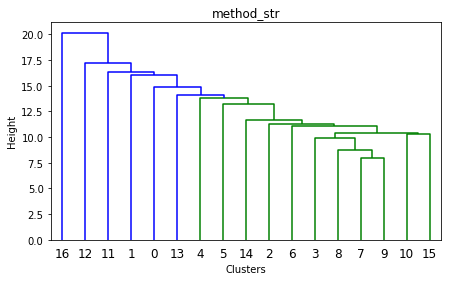

Number of clusters 2
Cophenet score is 0.956333


In [38]:
doHierarchialClustering(dtm,'euclidean',threshold=20)

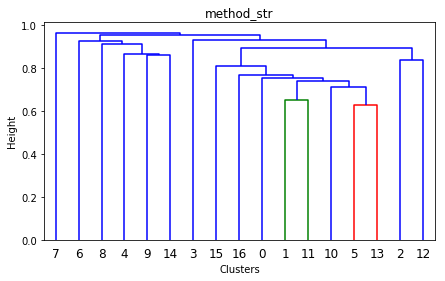

Number of clusters 7
Cophenet score is -0.235672


In [39]:
doHierarchialClustering(dtm,'cosine',threshold=.89)

* Learn about *Latent Dirichlet Allocation* to extract topics from your corpora, and measure each document on how much of each topic it contains. How do you interpret these topics?

Some **potential inspiration** below (but please keep your own story simple!):
* https://liferay.de.dariah.eu/tatom/topic_model_mallet.html covers a few examples of text analysis
* http://fantheory.viacom.com/
* https://pudding.cool/2017/02/vocabulary/

Additional resources on LDA (if you are interested): 
* https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d
* https://www.youtube.com/watch?v=DDq3OVp9dNA

[LDA Code](https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730)

[Grid Search LDA](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

In [40]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [50]:
n_components=2
# lda_model= LatentDirichletAllocation(n_topics=n_components, max_iter=5, learning_method='online',
#                                 learning_offset=50.,random_state=0,n_jobs=-1).fit(dtm)
lda_model = LatentDirichletAllocation(n_topics=2,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(dtm)

print(lda_model)  # Model attributes


# # Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(dtm))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(dtm))

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=2, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
Log Likelihood:  -11641.84002821157
Perplexity:  1130.139816415517
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'n_topics': 2, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


/home/hanifa/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [46]:
lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=2, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [ ]:
no_top_words = 100
display_topics(lda, vocab, no_top_words)

__GridSearch the LDA Model to find best fit__

In [62]:
def GridSearchLDA(dtm):
    # Define Search Param
    search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm)
    return model

In [65]:
model = GridSearchLDA(dtm)
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dtm))

/home/hanifa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -7928.47122813816
Model Perplexity:  1486.4210098579993


/home/hanifa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [55]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [57]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,silent,boyd,war,world,comedy,era,timeless,like,time,characters,cassidy,hopalong,william,films,role
Topic 1,boyd,william,soldiers,astor,silent,look,like,picture,great,boris,purser,princess,wolheim,karloff,lot
Topic 2,movies,heroes,like,early,story,scene,just,did,great,decades,classic,silent,modern,muslim,key
Topic 3,character,toni,work,end,use,familiar,words,lisa,kudrow,age,office,comic,advantage,current,society
Topic 4,surprised,like,office,actually,good,scenes,funny,just,accuracy,unexpected,clockwatchers,thing,feel,posey,watch
Topic 5,comedy,ship,louis,direction,wolheim,escape,young,beautiful,won,adventure,stuck,best,look,end,prison
Topic 6,thought,office,german,movies,comedy,space,best,just,academy,award,funny,camp,recently,arabia,fighting
Topic 7,life,dreams,actors,wonderful,roles,make,didn,working,close,character,performances,trying,big,busy,actresses
Topic 8,like,humor,life,shown,realism,just,best,thought,office,look,drama,character,beautiful,watch,space
Topic 9,wolheim,milestone,louis,astor,escape,boyd,scene,men,best,william,mary,scenes,arabian,knights,way


- Should remove common words like br and film and movie

- Also use some gridSearch to find optimal N-components (use perplexity score)

### Normalize your bags
In the above exercise, you may find it important to normalize your data.  One useful method when dealing with text is *Term Frequency - Inverse Document Frequency (TF-IDF)*. You can see more detail on this here: http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/.

Once you understand the concept, **express your data as TF-IDF vectors (instead of simple bag-of-words counts), and see if it changes your above story**. 

In [58]:
dtm_tfid = TfidfTransformer().fit_transform(dtm)
dtm_tfid = dtm_tfid.toarray() 

In [66]:
df=pd.DataFrame(dtm_tfid, columns=vocab)
df[vocab[0:20]].head()

,04,12,15,1927,1928,1931,1933,1st,20,2007,23,27,29,31,40,49,64,68,abbott,aboard
0,0.0,0.0,0.0,0.133664,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.093679,0.093679,0.093679,0.093679,0.093679,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.082943
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.0,0.135802,0.135802,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [60]:
del df

In [61]:
getFrequentWord(dtm_tfid)

Most frequent word: comedy


In [68]:
model = GridSearchLDA(dtm_tfid)
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfid))

/home/hanifa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -887.2045828397883
Model Perplexity:  194580.64651439677


/home/hanifa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [69]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,just,great,look,silent,time,adventure,louis,direction,early,films,like,camp,shown,thought,character
Topic 1,princess,boyd,high,wolheim,knights,make,arabian,astor,look,william,comedy,upper,rediscovered,art,private
Topic 2,dreams,manage,life,way,worked,managed,quite,make,speedy,story,escape,female,jobs,gets,ultimately
Topic 3,silent,lot,boyd,fighting,war,comedy,wollheim,inventive,world,lewis,era,timeless,1st,milestone,best
Topic 4,good,posey,heroes,funny,work,surprised,scenes,solid,familiar,movies,story,accuracy,character,office,german
Topic 5,dozen,early,admit,lead,variation,schtick,background,silents,lights,supposed,dressed,majority,major,viewed,beefcake
Topic 6,men,wolheim,knights,pows,caucasian,milestone,arabian,astor,scene,lewis,ship,mary,scenes,william,louis
Topic 7,just,great,look,silent,time,adventure,louis,direction,early,films,like,camp,shown,thought,character
Topic 8,ship,doesn,like,comedy,office,beautiful,purser,1927,life,boris,karloff,dangerfield,pvt,hush,gas
Topic 9,movies,office,rent,ve,space,mind,watching,watch,thought,apparently,whispers,superb,word,villain,product


### Show us your bags (Version 2)

Show and explain what one of your documents looks like as a TF-IDF vector below.  How is this different from a simple bag-of-words?

In [ ]:
# dtm[vocab=='br']

In [ ]:
np.unique(dtm_tfid[2,:])

In [ ]:
np.unique(dtm[2,:])

In [ ]:
dtm_tfid_sum = dtm_tfid.sum(axis=0)
vocab[dtm_tfid_sum.argmax(axis=0)]

# Chapter 2: Simple Supervised Learning with Text
Now that you are comfortable with treating text as numbers, we can try out supervised learning.  We'll use a labelled dataset of IMDB reviews to classify each review as 'positive' or 'negative'.  You can **find the data below:**

http://ai.stanford.edu/~amaas/data/sentiment/

Load in and process the data, then train a supervised learning model.  **You should achieve val or test set accuracy of 85%**. Pretty good for a simple bag, no?

[Sentiment Analysis in IMDB)[https://itnext.io/machine-learning-sentiment-analysis-of-movie-reviews-using-logisticregression-62e9622b4532]

# Chapter 3: Playing with Recurrent Neural Networks (RNN)
So far, we've only treated text as a simple bag, with reasonable results.  We'll now shift to a more complex representation of language: recurrent neural networks.  To do so, we need to process text at the word or character level, and capture the sequence of a document. 

Our task here is to build an RNN that 'eats up' sequences of characters in order to predict the next character in a sequence, for every step in the sequence of a document. This is a common (and fun) task, with lots of examples available online. 

For this task, use existing RNN APIs (don't code everything from scratch) from Keras or PyTorch. 

**Read up on RNNs and this exercise** below:
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/ - start here!
* https://github.com/martin-gorner/tensorflow-rnn-shakespeare - video, slides and code going through an example with Shakespeare
* http://killianlevacher.github.io/blog/posts/post-2016-03-01/post.html - another nice example based on Trump tweets

### Prepare your data

Our first step is to prepare our text. **Process your corpora into a format that can be used by an RNN, and walkthough one sequence below**.

An **example way to shape your data** for this task is as follows (feel free to play around with different structures):

*In this example your corpora starts with the string 'the cat and I'*
* RNN input: divide your text into sequences of 10 characters e.g. 'the cat an'
* RNN output: the 1 character immediately following RNN input sequences e.g. 'd'. 
* Note: You may or may not want to divide your text into overlapping strings (e.g. RNN input contains 'the cat an', 'he cat and', 'e cat and ', ...) . How is the model different in each case?
* Note: Your 'vocabulary' or `vocab_size` here is the number of unique characters in your text (and therefore the number of classes you want to predict)

### Generate text

Once the model is trained, we can use it to generate completely new text in the style of your training data.  **Train a model using your original choice of corpus below, and generate some sample sentences.** Don't worry too much about your loss / accuracy during training, but instead check on the text your model is generating. Your generated text should be somewhat coherent, i.e. similar to your training text in structure, and not excessively mispelled.

An **example model architecture** is as follows (feel free to play around with different structures):
* Embedding (for each character in your vocab) of dimension 64
* Dropout of 20% for the embedding input to the RNN
* 2 LSTM layers, each of dimension 512 (play around with the number and dimension of hidden layers)
* Dropout of 50% for each LSTM layer
* Dense softmax layer of same dimension as your vocab size (e.g. if your vocab size is 100, this layer is the probabilty that your output is one of 100 possible characters)
    
**You should understand what each of the above elements are and how they work at a high level by the end of this week's exercise.**

### Generalizing the exercise
How do you think you can apply what you learned in the above exercise to other problems involving text? For example, how would you tackle the previous IMDB sentiment classification task using an RNN architecture? **Discuss below.**

(*Bonus*: create an RNN model for the IMDB classification task and discuss your results. How does the performance compare to your bag of words model?)

# Chapter 4: RNNs from scratch
Now that you understand how to use RNNs, it's time to build a basic one from scratch.  You won't understand how they work until you get stuck in the weeds! 

### Generate text (Version 2)
Your task is now to **build the forward pass of a simple RNN, without using any existing RNN APIs**. You can use PyTorch or Tensorflow (Keras is too high level for this exercise), both of which will automatically handle backpropagation for you.  If you use Tensorflow, please research and use Eager execution - it replaces Tensorflow's default graph / session framework, which is very difficult to learn and debug.

Similar to last week's exercise, create a class for your network (write forward and loss steps, allowing PyTorch or Tensorflow to handle backpropagation for you).  Consider appropriate sizes for your input, hidden and output layers - your __init__ method should take in the params `hidden_size`, `vocab_size`, and `embedding_size` (if you use embeddings). Using these variables, you should initialise three weight layers `input_layer`, `hidden_layer`, and `output_layer`.  In an RNN, you will also have to deal with another item - the `hidden_state`. (Note: your RNN structure may vary slightly from this depending on your learning materials, but the key part is always `hidden_state`)

You should **train your RNN on the same data and task as in Chapter 3.**

**How do the results of your basic RNN compare to your model in Chapter 3?**  What do you think explains the difference in performance? Discuss below.

Some relevant resources on LSTMs (and RNN theory) below if you are interested:
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://www.youtube.com/watch?v=93rzMHtYT_0&list=LLpNVCNE9cYqVrjb2O8bZUGg&index=2&t=0s
* https://www.youtube.com/watch?v=zQxm3Upr3_I
* http://harinisuresh.com/2016/10/09/lstms/

### Bonus Challenges (not required!):
1. Build the forward pass of an LSTM, without using any existing RNN APIs (as above, with PyTorch or Tensorflow)
1. Build a basic RNN or LSTM in Numpy - including forward pass as well as backpropogation